In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import pickle
import os
import h5py
import collections as cl
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import random
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
param_grid = {'C': [10**k for k in range(-10, 6, 2)]}  
scoring = 'roc_auc'; cv = 3; random_state=42
random.seed(random_state)

In [3]:
with open('class-map-10.json', 'r') as f: # only consider 10 classes of Openmic dataset
    class_map = json.load(f)

# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
class_align = {'cello': 'cel',
               'clarinet': 'cla',
               'flute': 'flu',
               'guitar': ['gac', 'gel'],
               'organ': 'org',
               'piano': 'pia',
               'saxophone': 'sax',
               'trumpet': 'tru',
               'violin': 'vio',
               'voice': 'voi'}

# irmas genre information: country-folk ([cou_fol]), classical ([cla]), pop-rock ([pop-roc]), latin-soul ([lat-sou]).
aligned_genre = ['pop_roc', 'jazz_blue', 'classical', 'country_folk', 'latin_soul']

# use a Pandas DataFrame to record all results and save into a csv file later
result_all = pd.DataFrame({'instrument': [],
                          'train_set': [],
                          'test_set': [],
                          'precision': [],
                          'recall': [],
                          'f1-score': [],
                          'support': [],
                          'accuracy': [],
                          'roc_auc': [],
                          'ap': [],
                          'embedding': [],
                         })

In [4]:
# Load embeddings and align classes

In [5]:
embedding = 'vggish'
debias_method = ''

data = h5py.File('feature.h5', 'r')

In [6]:
###### IRMAS data ######
dataset = 'irmas'
X_train_irmas = np.array(data[embedding][dataset]['X_train_irmas'])
X_test_irmas = np.array(data[embedding][dataset]['X_test_irmas'])

Y_train_irmas = np.array(data[embedding][dataset]['Y_train_irmas'])
Y_test_irmas = np.array(data[embedding][dataset]['Y_test_irmas'])

genre_train_irmas = np.array(data[embedding][dataset]['genre_train_irmas'])

In [7]:
###### OpenMIC data ######
dataset = 'openmic'
X_train_openmic = np.array(data[embedding][dataset]['X_train_openmic'])
X_test_openmic = np.array(data[embedding][dataset]['X_test_openmic'])

Y_train_openmic = np.array(data[embedding][dataset]['Y_train_openmic'])
Y_test_openmic = np.array(data[embedding][dataset]['Y_test_openmic'])

Y_mask_train = np.array(data[embedding][dataset]['Y_mask_train'])
Y_mask_test = np.array(data[embedding][dataset]['Y_mask_test'])

genre_train_openmic = np.array(data[embedding][dataset]['genre_train_openmic'])

In [8]:
print(X_train_irmas.shape, X_test_irmas.shape, Y_train_irmas.shape, Y_train_irmas.shape, genre_train_irmas.shape)
print(X_train_openmic.shape, X_test_openmic.shape, Y_train_openmic.shape, Y_train_openmic.shape, genre_train_openmic.shape)

(5039, 128) (1666, 128) (5039,) (5039,) (5039,)
(14915, 128) (5085, 128) (14915, 20) (14915, 20) (14915,)


In [9]:
Y_train_irmas_ori = np.load('Y_train_irmas.npz')['arr_0']
genre_train_openmic_ori = np.load('genre_train_openmic.npz')['arr_0']

encoder = LabelEncoder()
encoder.fit_transform(Y_train_irmas_ori)
Y_train_irmas = encoder.inverse_transform(Y_train_irmas)
Y_test_irmas = encoder.inverse_transform(Y_test_irmas)

encoder.fit(genre_train_openmic_ori)
genre_train_irmas = encoder.inverse_transform(genre_train_irmas)
genre_train_openmic = encoder.inverse_transform(genre_train_openmic)

In [10]:
cl.Counter(Y_train_irmas)

Counter({'guitar': 1051,
         'piano': 551,
         'trumpet': 427,
         'violin': 437,
         'voice': 587,
         'clarinet': 378,
         'saxophone': 476,
         'flute': 330,
         'cello': 294,
         'organ': 508})

In [11]:
cl.Counter(genre_train_openmic)

Counter({'pop_roc': 826,
         'other': 11335,
         'country_folk': 1053,
         'jazz_blue': 778,
         'latin_soul': 76,
         'classical': 847})

# irmas->irmas

In [12]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'irmas', 'irmas' 

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_align:

    ###### OpenMIC
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst_openmic = X_train_openmic[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_train_inst_openmic = Y_train_openmic[train_inst, inst_num] >= 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst_openmic = X_test_openmic[test_inst]
    Y_test_inst_openmic = Y_test_openmic[test_inst, inst_num] >= 0.5

    ###### IRMAS
    # get the training and testing labels for each instrument
    X_train_inst_irmas = X_train_irmas
    X_test_inst_irmas = X_test_irmas
    Y_train_inst_irmas = Y_train_irmas==instrument
    Y_test_inst_irmas = Y_test_irmas==instrument

    X_train_inst = X_train_inst_irmas
    Y_train_inst = Y_train_inst_irmas
    X_test_inst = X_test_inst_irmas 
    Y_test_inst = Y_test_inst_irmas

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=random_state, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_train_inst)

    # predict
    Y_pred_inst = clf.predict(X_test_inst)
    # Get prediction scores for the positive class
    Y_pred_scores = clf.predict_proba(X_test_inst)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_test_inst, Y_pred_inst))
    
    model_auc = roc_auc_score(Y_test_inst, Y_pred_scores)
    model_ap = average_precision_score(Y_test_inst, Y_pred_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap, embedding + debias_method]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.99      0.88      0.93      1572
        True       0.29      0.86      0.44        94

    accuracy                           0.88      1666
   macro avg       0.64      0.87      0.68      1666
weighted avg       0.95      0.88      0.90      1666

ROC-AUC = 0.938		AP = 0.631
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.99      0.82      0.89      1539
        True       0.28      0.85      0.42       127

    accuracy                           0.82      1666
   macro avg       0.63      0.83      0.66      1666
weighted avg       0.93      0.82      0.86      1666

ROC-AUC = 0.902		AP = 0.598
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.98      0.87    

# openmic->irmas

In [13]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'openmic', 'irmas' 

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_align:

    ###### OpenMIC
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst_openmic = X_train_openmic[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_train_inst_openmic = Y_train_openmic[train_inst, inst_num] >= 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst_openmic = X_test_openmic[test_inst]
    Y_test_inst_openmic = Y_test_openmic[test_inst, inst_num] >= 0.5

    ###### IRMAS
    # get the training and testing labels for each instrument
    X_train_inst_irmas = X_train_irmas
    X_test_inst_irmas = X_test_irmas
    Y_train_inst_irmas = Y_train_irmas==instrument
    Y_test_inst_irmas = Y_test_irmas==instrument

    X_train_inst = X_train_inst_openmic
    Y_train_inst = Y_train_inst_openmic
    X_test_inst = X_test_inst_irmas 
    Y_test_inst = Y_test_inst_irmas

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=random_state, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_train_inst)

    # predict
    Y_pred_inst = clf.predict(X_test_inst)
    # Get prediction scores for the positive class
    Y_pred_scores = clf.predict_proba(X_test_inst)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_test_inst, Y_pred_inst))
    
    model_auc = roc_auc_score(Y_test_inst, Y_pred_scores)
    model_ap = average_precision_score(Y_test_inst, Y_pred_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap, embedding + debias_method]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.99      0.76      0.86      1572
        True       0.17      0.81      0.28        94

    accuracy                           0.76      1666
   macro avg       0.58      0.78      0.57      1666
weighted avg       0.94      0.76      0.83      1666

ROC-AUC = 0.859		AP = 0.382
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.99      0.69      0.81      1539
        True       0.19      0.90      0.32       127

    accuracy                           0.70      1666
   macro avg       0.59      0.79      0.56      1666
weighted avg       0.93      0.70      0.77      1666

ROC-AUC = 0.894		AP = 0.551
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.98      0.48    

# openmic+ir_inst->irmas

In [14]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'openmic+ir_inst', 'irmas' 

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_align:

    ###### OpenMIC
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst_openmic = X_train_openmic[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_train_inst_openmic = Y_train_openmic[train_inst, inst_num] >= 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst_openmic = X_test_openmic[test_inst]
    Y_test_inst_openmic = Y_test_openmic[test_inst, inst_num] >= 0.5

    ###### IRMAS
    # get the training and testing labels for each instrument
    X_train_inst_irmas = X_train_irmas
    X_test_inst_irmas = X_test_irmas
    Y_train_inst_irmas = Y_train_irmas==instrument
    Y_test_inst_irmas = Y_test_irmas==instrument

    X_train_inst = np.vstack((X_train_inst_openmic, X_train_inst_irmas[Y_train_inst_irmas]))
    Y_train_inst = np.hstack((Y_train_inst_openmic, Y_train_inst_irmas[Y_train_inst_irmas]))
    X_test_inst = X_test_inst_irmas 
    Y_test_inst = Y_test_inst_irmas

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=random_state, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_train_inst)

    # predict
    Y_pred_inst = clf.predict(X_test_inst)
    # Get prediction scores for the positive class
    Y_pred_scores = clf.predict_proba(X_test_inst)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_test_inst, Y_pred_inst))
    
    model_auc = roc_auc_score(Y_test_inst, Y_pred_scores)
    model_ap = average_precision_score(Y_test_inst, Y_pred_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap, embedding + debias_method]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.99      0.53      0.69      1572
        True       0.10      0.88      0.18        94

    accuracy                           0.55      1666
   macro avg       0.54      0.71      0.44      1666
weighted avg       0.94      0.55      0.66      1666

ROC-AUC = 0.838		AP = 0.423
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.98      0.54      0.70      1539
        True       0.14      0.90      0.24       127

    accuracy                           0.57      1666
   macro avg       0.56      0.72      0.47      1666
weighted avg       0.92      0.57      0.66      1666

ROC-AUC = 0.841		AP = 0.428
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.98      0.39    

# openmic+ir_noninst->irmas

In [15]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'openmic+ir_noninst', 'irmas' 

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_align:

    ###### OpenMIC
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst_openmic = X_train_openmic[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_train_inst_openmic = Y_train_openmic[train_inst, inst_num] >= 0.5
    Y_train_noninst_openmic = Y_train_openmic[train_inst, inst_num] < 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst_openmic = X_test_openmic[test_inst]
    Y_test_inst_openmic = Y_test_openmic[test_inst, inst_num] >= 0.5

    ###### IRMAS
    # get the training and testing labels for each instrument
    X_train_inst_irmas = X_train_irmas
    X_test_inst_irmas = X_test_irmas
    Y_train_inst_irmas = Y_train_irmas==instrument
    Y_train_noninst_irmas = Y_train_irmas!=instrument
    Y_test_inst_irmas = Y_test_irmas==instrument

    X_train_inst = np.vstack((X_train_inst_openmic, X_train_inst_irmas[Y_train_noninst_irmas]))
    Y_train_inst = np.hstack((Y_train_inst_openmic, Y_train_inst_irmas[Y_train_noninst_irmas]))
    X_test_inst = X_test_inst_irmas 
    Y_test_inst = Y_test_inst_irmas

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=random_state, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_train_inst)

    # predict
    Y_pred_inst = clf.predict(X_test_inst)
    # Get prediction scores for the positive class
    Y_pred_scores = clf.predict_proba(X_test_inst)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_test_inst, Y_pred_inst))
    
    model_auc = roc_auc_score(Y_test_inst, Y_pred_scores)
    model_ap = average_precision_score(Y_test_inst, Y_pred_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap, embedding + debias_method]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.98      0.93      0.96      1572
        True       0.40      0.74      0.52        94

    accuracy                           0.92      1666
   macro avg       0.69      0.84      0.74      1666
weighted avg       0.95      0.92      0.93      1666

ROC-AUC = 0.908		AP = 0.606
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.98      0.86      0.92      1539
        True       0.32      0.78      0.46       127

    accuracy                           0.86      1666
   macro avg       0.65      0.82      0.69      1666
weighted avg       0.93      0.86      0.88      1666

ROC-AUC = 0.895		AP = 0.581
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.97      0.94    

# all->irmas

In [16]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'all', 'irmas' 

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_align:

    ###### OpenMIC
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst_openmic = X_train_openmic[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_train_inst_openmic = Y_train_openmic[train_inst, inst_num] >= 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst_openmic = X_test_openmic[test_inst]
    Y_test_inst_openmic = Y_test_openmic[test_inst, inst_num] >= 0.5

    ###### IRMAS
    # get the training and testing labels for each instrument
    X_train_inst_irmas = X_train_irmas
    X_test_inst_irmas = X_test_irmas
    Y_train_inst_irmas = Y_train_irmas==instrument
    Y_test_inst_irmas = Y_test_irmas==instrument

    X_train_inst = np.vstack((X_train_inst_openmic, X_train_inst_irmas))
    Y_train_inst = np.hstack((Y_train_inst_openmic, Y_train_inst_irmas))
    X_test_inst = X_test_inst_irmas 
    Y_test_inst = Y_test_inst_irmas

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=random_state, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_train_inst)

    # predict
    Y_pred_inst = clf.predict(X_test_inst)
    # Get prediction scores for the positive class
    Y_pred_scores = clf.predict_proba(X_test_inst)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_test_inst, Y_pred_inst))
    
    model_auc = roc_auc_score(Y_test_inst, Y_pred_scores)
    model_ap = average_precision_score(Y_test_inst, Y_pred_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap, embedding + debias_method]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.99      0.90      0.94      1572
        True       0.34      0.84      0.48        94

    accuracy                           0.90      1666
   macro avg       0.66      0.87      0.71      1666
weighted avg       0.95      0.90      0.92      1666

ROC-AUC = 0.938		AP = 0.628
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.98      0.84      0.91      1539
        True       0.30      0.83      0.44       127

    accuracy                           0.84      1666
   macro avg       0.64      0.84      0.67      1666
weighted avg       0.93      0.84      0.87      1666

ROC-AUC = 0.915		AP = 0.621
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.98      0.90    

# openmic->openmic

In [17]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'openmic', 'openmic' 

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_align:

    ###### OpenMIC
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst_openmic = X_train_openmic[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_train_inst_openmic = Y_train_openmic[train_inst, inst_num] >= 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst_openmic = X_test_openmic[test_inst]
    Y_test_inst_openmic = Y_test_openmic[test_inst, inst_num] >= 0.5

    ###### IRMAS
    # get the training and testing labels for each instrument
    X_train_inst_irmas = X_train_irmas
    X_test_inst_irmas = X_test_irmas
    Y_train_inst_irmas = Y_train_irmas==instrument
    Y_test_inst_irmas = Y_test_irmas==instrument

    X_train_inst = X_train_inst_openmic
    Y_train_inst = Y_train_inst_openmic
    X_test_inst = X_test_inst_openmic
    Y_test_inst = Y_test_inst_openmic

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=random_state, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_train_inst)

    # predict
    Y_pred_inst = clf.predict(X_test_inst)
    # Get prediction scores for the positive class
    Y_pred_scores = clf.predict_proba(X_test_inst)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_test_inst, Y_pred_inst))
    
    model_auc = roc_auc_score(Y_test_inst, Y_pred_scores)
    model_ap = average_precision_score(Y_test_inst, Y_pred_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap, embedding + debias_method]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.86      0.76      0.81       259
        True       0.76      0.86      0.80       226

    accuracy                           0.81       485
   macro avg       0.81      0.81      0.81       485
weighted avg       0.81      0.81      0.81       485

ROC-AUC = 0.884		AP = 0.845
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.90      0.60      0.72       503
        True       0.34      0.75      0.47       137

    accuracy                           0.63       640
   macro avg       0.62      0.68      0.59       640
weighted avg       0.78      0.63      0.67       640

ROC-AUC = 0.745		AP = 0.418
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.86      0.66    

# irmas->openmic

In [18]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'irmas', 'openmic' 

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_align:

    ###### OpenMIC
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst_openmic = X_train_openmic[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_train_inst_openmic = Y_train_openmic[train_inst, inst_num] >= 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst_openmic = X_test_openmic[test_inst]
    Y_test_inst_openmic = Y_test_openmic[test_inst, inst_num] >= 0.5

    ###### IRMAS
    # get the training and testing labels for each instrument
    X_train_inst_irmas = X_train_irmas
    X_test_inst_irmas = X_test_irmas
    Y_train_inst_irmas = Y_train_irmas==instrument
    Y_test_inst_irmas = Y_test_irmas==instrument

    X_train_inst = X_train_inst_irmas
    Y_train_inst = Y_train_inst_irmas
    X_test_inst = X_test_inst_openmic
    Y_test_inst = Y_test_inst_openmic

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=random_state, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_train_inst)

    # predict
    Y_pred_inst = clf.predict(X_test_inst)
    # Get prediction scores for the positive class
    Y_pred_scores = clf.predict_proba(X_test_inst)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_test_inst, Y_pred_inst))
    
    model_auc = roc_auc_score(Y_test_inst, Y_pred_scores)
    model_ap = average_precision_score(Y_test_inst, Y_pred_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap, embedding + debias_method]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.75      0.58      0.66       259
        True       0.62      0.78      0.69       226

    accuracy                           0.67       485
   macro avg       0.69      0.68      0.67       485
weighted avg       0.69      0.67      0.67       485

ROC-AUC = 0.751		AP = 0.700
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.84      0.64      0.73       503
        True       0.30      0.57      0.39       137

    accuracy                           0.62       640
   macro avg       0.57      0.60      0.56       640
weighted avg       0.73      0.62      0.66       640

ROC-AUC = 0.677		AP = 0.355
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.81      0.52    

# irmas+op_inst->openmic

In [19]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'irmas+op_inst', 'openmic' 

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_align:

    ###### OpenMIC
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst_openmic = X_train_openmic[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_train_inst_openmic = Y_train_openmic[train_inst, inst_num] >= 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst_openmic = X_test_openmic[test_inst]
    Y_test_inst_openmic = Y_test_openmic[test_inst, inst_num] >= 0.5

    ###### IRMAS
    # get the training and testing labels for each instrument
    X_train_inst_irmas = X_train_irmas
    X_test_inst_irmas = X_test_irmas
    Y_train_inst_irmas = Y_train_irmas==instrument
    Y_test_inst_irmas = Y_test_irmas==instrument

    X_train_inst = np.vstack((X_train_inst_openmic[Y_train_inst_openmic], X_train_inst_irmas))
    Y_train_inst = np.hstack((Y_train_inst_openmic[Y_train_inst_openmic], Y_train_inst_irmas))
    X_test_inst = X_test_inst_openmic
    Y_test_inst = Y_test_inst_openmic

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=random_state, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_train_inst)

    # predict
    Y_pred_inst = clf.predict(X_test_inst)
    # Get prediction scores for the positive class
    Y_pred_scores = clf.predict_proba(X_test_inst)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_test_inst, Y_pred_inst))
    
    model_auc = roc_auc_score(Y_test_inst, Y_pred_scores)
    model_ap = average_precision_score(Y_test_inst, Y_pred_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap, embedding + debias_method]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.88      0.44      0.59       259
        True       0.59      0.93      0.72       226

    accuracy                           0.67       485
   macro avg       0.73      0.68      0.65       485
weighted avg       0.74      0.67      0.65       485

ROC-AUC = 0.747		AP = 0.669
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.92      0.37      0.52       503
        True       0.27      0.88      0.42       137

    accuracy                           0.48       640
   macro avg       0.59      0.62      0.47       640
weighted avg       0.78      0.48      0.50       640

ROC-AUC = 0.669		AP = 0.332
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.89      0.35    

# irmas+op_noninst->openmic

In [20]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'irmas+op_noninst', 'openmic' 

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_align:

    ###### OpenMIC
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst_openmic = X_train_openmic[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_train_inst_openmic = Y_train_openmic[train_inst, inst_num] >= 0.5
    Y_train_noninst_openmic = Y_train_openmic[train_inst, inst_num] < 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst_openmic = X_test_openmic[test_inst]
    Y_test_inst_openmic = Y_test_openmic[test_inst, inst_num] >= 0.5

    ###### IRMAS
    # get the training and testing labels for each instrument
    X_train_inst_irmas = X_train_irmas
    X_test_inst_irmas = X_test_irmas
    Y_train_inst_irmas = Y_train_irmas==instrument
    Y_train_noninst_irmas = Y_train_irmas!=instrument
    Y_test_inst_irmas = Y_test_irmas==instrument

    X_train_inst = np.vstack((X_train_inst_openmic[Y_train_noninst_openmic], X_train_inst_irmas))
    Y_train_inst = np.hstack((Y_train_inst_openmic[Y_train_noninst_openmic], Y_train_inst_irmas))
    X_test_inst = X_test_inst_openmic
    Y_test_inst = Y_test_inst_openmic

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=random_state, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_train_inst)

    # predict
    Y_pred_inst = clf.predict(X_test_inst)
    # Get prediction scores for the positive class
    Y_pred_scores = clf.predict_proba(X_test_inst)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_test_inst, Y_pred_inst))
    
    model_auc = roc_auc_score(Y_test_inst, Y_pred_scores)
    model_ap = average_precision_score(Y_test_inst, Y_pred_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap, embedding + debias_method]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.77      0.75      0.76       259
        True       0.72      0.75      0.73       226

    accuracy                           0.75       485
   macro avg       0.75      0.75      0.75       485
weighted avg       0.75      0.75      0.75       485

ROC-AUC = 0.831		AP = 0.787
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.83      0.81      0.82       503
        True       0.37      0.41      0.39       137

    accuracy                           0.72       640
   macro avg       0.60      0.61      0.60       640
weighted avg       0.73      0.72      0.73       640

ROC-AUC = 0.680		AP = 0.356
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.80      0.81    

# all->openmic

In [21]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'all', 'openmic' 

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_align:

    ###### OpenMIC
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst_openmic = X_train_openmic[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_train_inst_openmic = Y_train_openmic[train_inst, inst_num] >= 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst_openmic = X_test_openmic[test_inst]
    Y_test_inst_openmic = Y_test_openmic[test_inst, inst_num] >= 0.5

    ###### IRMAS
    # get the training and testing labels for each instrument
    X_train_inst_irmas = X_train_irmas
    X_test_inst_irmas = X_test_irmas
    Y_train_inst_irmas = Y_train_irmas==instrument
    Y_test_inst_irmas = Y_test_irmas==instrument

    X_train_inst = np.vstack((X_train_inst_openmic, X_train_inst_irmas))
    Y_train_inst = np.hstack((Y_train_inst_openmic, Y_train_inst_irmas))
    X_test_inst = X_test_inst_openmic
    Y_test_inst = Y_test_inst_openmic

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=random_state, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_train_inst)

    # predict
    Y_pred_inst = clf.predict(X_test_inst)
    # Get prediction scores for the positive class
    Y_pred_scores = clf.predict_proba(X_test_inst)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_test_inst, Y_pred_inst))
    
    model_auc = roc_auc_score(Y_test_inst, Y_pred_scores)
    model_ap = average_precision_score(Y_test_inst, Y_pred_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap, embedding + debias_method]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.88      0.56      0.69       259
        True       0.65      0.91      0.76       226

    accuracy                           0.73       485
   macro avg       0.76      0.74      0.72       485
weighted avg       0.77      0.73      0.72       485

ROC-AUC = 0.811		AP = 0.758
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.88      0.52      0.65       503
        True       0.29      0.73      0.42       137

    accuracy                           0.56       640
   macro avg       0.58      0.62      0.53       640
weighted avg       0.75      0.56      0.60       640

ROC-AUC = 0.705		AP = 0.394
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.85      0.46    

# save result

In [22]:
# save all result into a csv file
# result_all.to_csv('results/result_' + embedding + debias_method + '_trainboth.csv', index=False)
result_all.to_csv('results/result_' + embedding + '_trainall.csv', index=False)

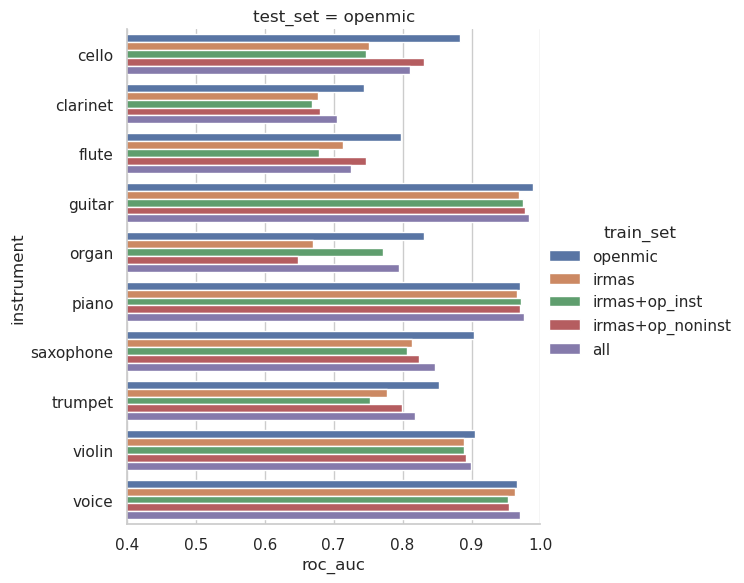

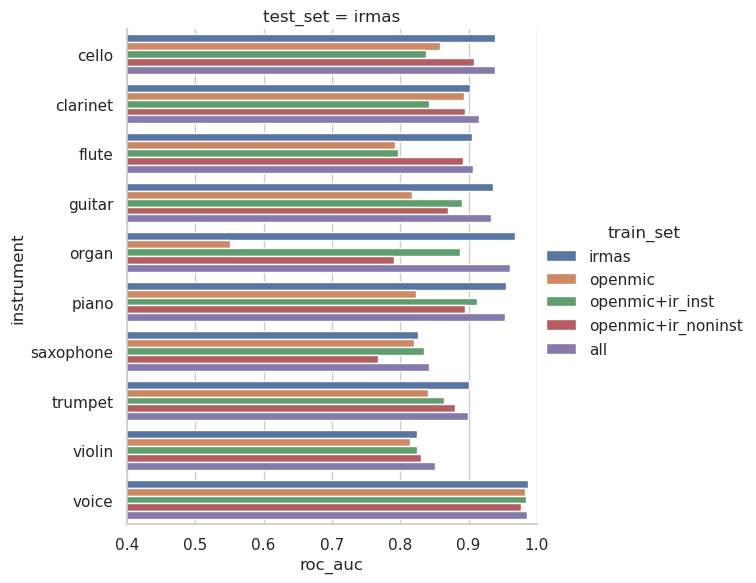

In [23]:
openmic_test = result_all.loc[(result_all['test_set'] == 'openmic')]
irmas_test = result_all.loc[(result_all['test_set'] == 'irmas')] # .reset_index(drop=True)
openmic_test.to_csv('results/openmic_test_' + embedding + debias_method + '_trainall.csv', index=False)
irmas_test.to_csv('results/irmas_test_' + embedding + debias_method + '_trainall.csv', index=False)

sns.set_theme(context='notebook', style='whitegrid', palette='deep')

df = pd.read_csv('results/openmic_test_' + embedding + debias_method + '_trainall.csv')
sns.catplot(data=df, col='test_set', y='instrument', x='roc_auc', hue='train_set', kind='bar', 
            height=6, aspect=1)
plt.xlim([.4,1])
plt.savefig('results/openmic_test_' + embedding + debias_method + '_trainall.pdf')

df = pd.read_csv('results/irmas_test_' + embedding + debias_method + '_trainall.csv')
sns.catplot(data=df, col='test_set', y='instrument', x='roc_auc', hue='train_set', kind='bar', 
            height=6, aspect=1)
plt.xlim([.4,1])

plt.savefig('results/irmas_test_' + embedding + debias_method + '_trainall.pdf')